In [1]:
import torch
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  
from matplotlib import pyplot as plt
import tensorflow
import shap
from sklearn.metrics import f1_score, balanced_accuracy_score

shap.initjs()    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Preprocess and Load the data

In [2]:
def remove_label(df):
    # Extract the 'HeartDisease' column as the labels
    labels = df['HeartDisease']
    
    # Remove the 'HeartDisease' column from the dataframe
    df_without_heart_disease = df.drop(columns=['HeartDisease'])
    
    # Return the modified DataFrame and the labels
    return df_without_heart_disease, labels

def process_cat_vars(df):
    """
    Function to preprocess the data, including encoding categorical variables and 
    applying one-hot encoding to certain columns. This function is designed to be applied
    to both the training and test sets.
    
    Parameters:
    df (DataFrame): The input dataframe containing the features and the target label.

    Returns:
    DataFrame: The preprocessed dataframe
    """
    # Encode categorical variables
    # Male is 1, female is 0 for 'Sex'
    df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
    
    # 'ExerciseAngina' : Yes is 1 and No is 0
    df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})
    
    # 'ST_Slope': Up is 1, Flat is 0, Down is -1
    df['ST_Slope'] = df['ST_Slope'].map({'Up': 1, 'Flat': 0, 'Down': -1})

    # One hot encoding for categorical columns that have more than two categories
    df_encoded = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG'], dtype=int)
    
    return df_encoded

df_train = pd.read_csv(os.path.join('heart_failure', 'train_val_split.csv'))
df_test = pd.read_csv(os.path.join('heart_failure', 'test_split.csv'))
df_train, y_train = remove_label(df_train)
df_test, y_test = remove_label(df_test)
df_train = process_cat_vars(df_train)
df_test = process_cat_vars(df_test)

X_train = torch.tensor(df_train.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(df_test.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Ensure that it worked

In [3]:
print("Train set shape:", df_train.shape)
df_train.head()



Train set shape: (734, 16)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,1,140,289,0,172,0,0.0,1,0,1,0,0,0,1,0
1,37,1,130,283,0,98,0,0.0,1,0,1,0,0,0,0,1
2,48,0,138,214,0,108,1,1.5,0,1,0,0,0,0,1,0
3,54,1,150,195,0,122,0,0.0,1,0,0,1,0,0,1,0
4,39,1,120,339,0,170,0,0.0,1,0,0,1,0,0,1,0


In [4]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu1 = torch.nn.ReLU()
        #self.relu2 = torch.nn.ReLU()
        #self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        #x = self.fc2(x)
        #x = self.relu2(x)
        x = self.fc3(x)
        return x

model = MLP(input_size=df_train.shape[1], hidden_size=64, output_size=1).to(device)

Epochs: 100%|██████████| 100/100 [00:00<00:00, 116.59epoch/s]


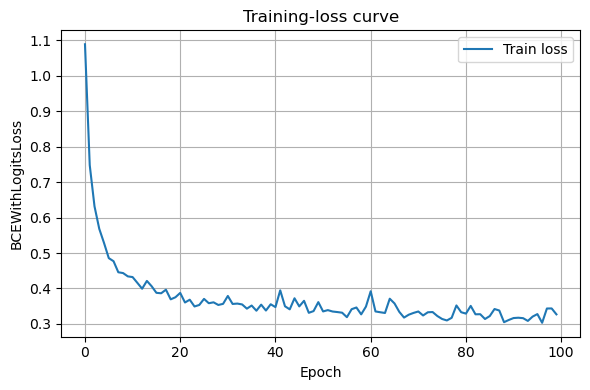

In [5]:
batch_size = 32
learning_rate = 0.001
num_epochs = 100
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader  = DataLoader(train_dataset,
                           batch_size=batch_size,
                           shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion  = torch.nn.BCEWithLogitsLoss()

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

loss_history = []

for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs", unit="epoch"):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
       

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)

    #scheduler.step()    

plt.figure(figsize=(6, 4))          
plt.plot(loss_history, label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogitsLoss")
plt.title("Training-loss curve")
plt.grid(True)
plt.legend()
plt.tight_layout()             
plt.show()


In [6]:
from sklearn.metrics import f1_score
batch_size = 1

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader  = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=False)


all_logits = []
all_labels = []
test_running_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        logits = model(X_batch)                      
        loss   = criterion(logits, y_batch)

        test_running_loss += loss.item() * X_batch.size(0)

        all_logits.append(logits.cpu())
        all_labels.append(y_batch.cpu())

test_loss = test_running_loss / len(test_loader.dataset)
logits  = torch.cat(all_logits).squeeze()        
targets = torch.cat(all_labels).squeeze()         

probs = torch.sigmoid(logits)                   
preds = (probs >= 0.5).int() 
f1  = f1_score(targets.numpy(), preds.numpy())
bal = balanced_accuracy_score(targets.numpy(), preds.numpy())   # add this

print(f"Average test loss: {test_loss:.4f}")
print(f"Test F1 score   : {f1:.4f}")
print(f"Balanced ACC    : {bal:.4f}")     
accuracy = (preds == targets).float().mean()                
print(f"Test accuracy   : {accuracy:.4f}")

Average test loss: 0.4679
Test F1 score   : 0.8571
Balanced ACC    : 0.8014
Test accuracy   : 0.8207


/var/folders/v9/_5syljlj46x7sjwvgknn5gmr0000gn/T/ipykernel_68571/3407142812.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


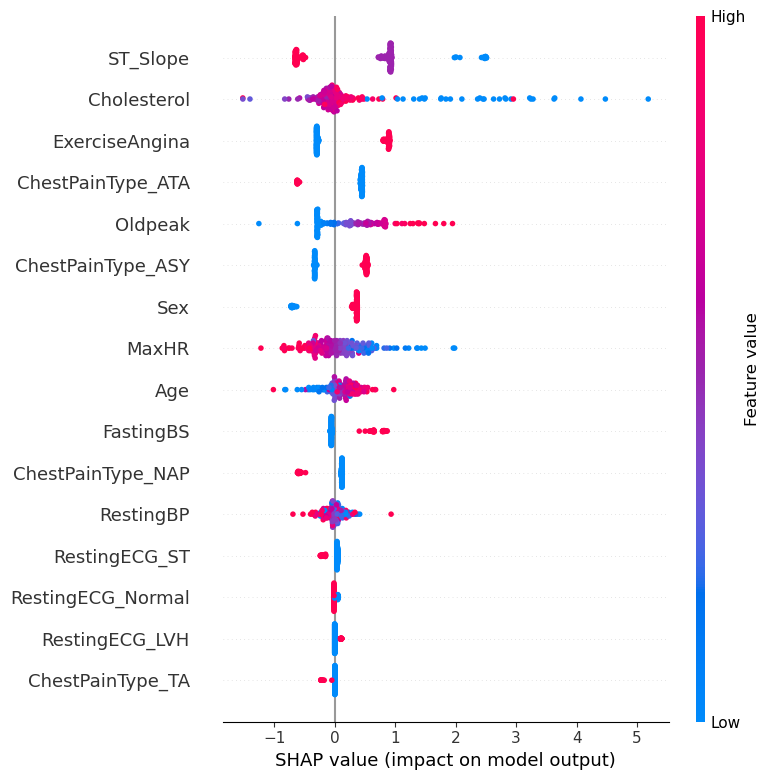

In [7]:
model.eval()

background = X_train[:100]   
explainer = shap.DeepExplainer(model, background)
data = X_test
shap_vals = explainer.shap_values(data).squeeze()
shap.summary_plot(
    shap_vals,
    data.cpu().numpy(),         
    feature_names=df_train.columns,
    plot_type="dot",
    show=True,
); 

In [8]:
positive_indices = [i for i, x in enumerate(y_test) if x == 1][:2]
negative_indices = [i for i, x in enumerate(y_test) if x == 0][:2]

print("Positive indices:", positive_indices)
print("Negative indices:", negative_indices)

Positive indices: [0, 1]
Negative indices: [6, 10]


# Positives

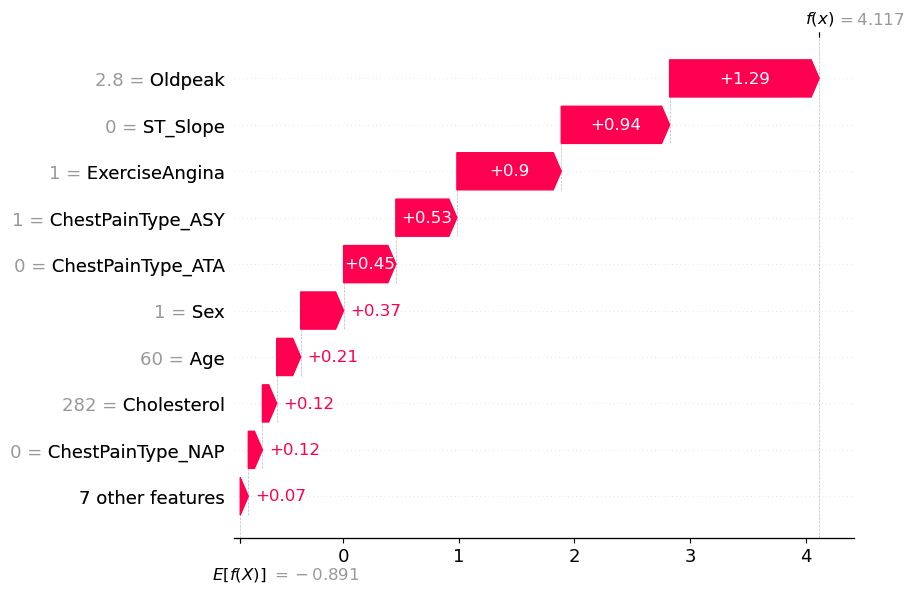

In [9]:
i = 0
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= df_train.columns.tolist()
        ),
        max_display=10, show=True
    )

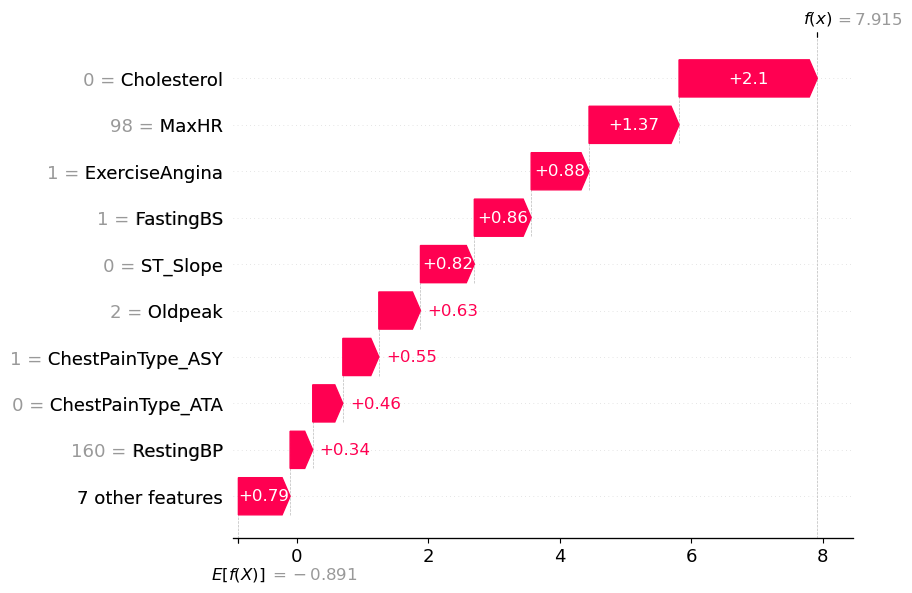

In [10]:
i = 1
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= df_train.columns.tolist()
        ),
        max_display=10, show=True
    )

# Negatives

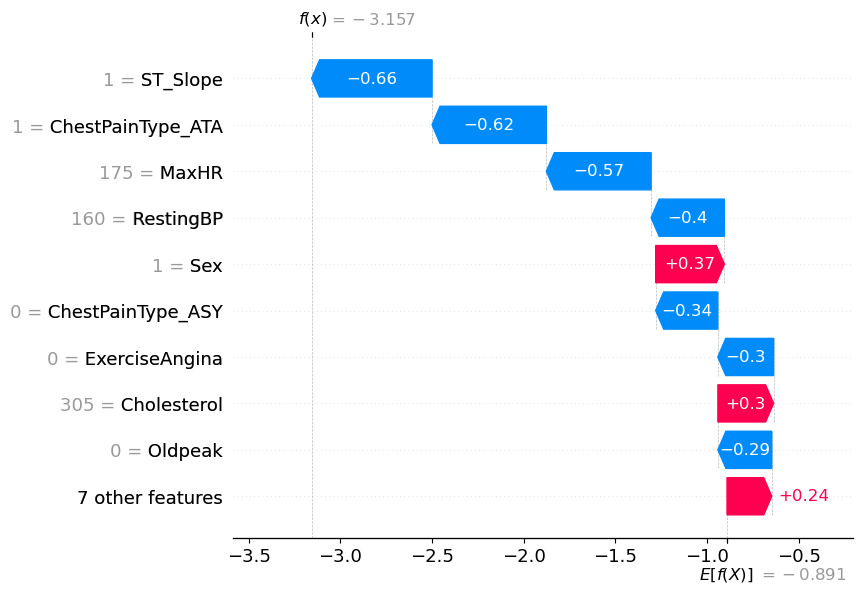

In [11]:
i = 6
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= df_train.columns.tolist()
        ),
        max_display=10, show=True
    )

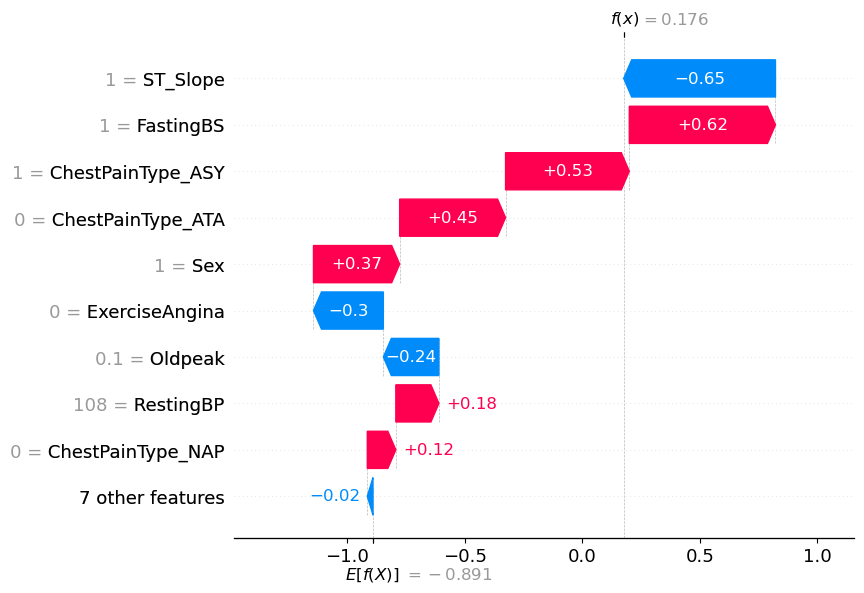

In [12]:
i = 10
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= df_train.columns.tolist()
        ),
        max_display=10, show=True
    )